In [1]:
%load_ext autoreload
%autoreload 2

import os

subj = "Subj1"
N_STAGES = 9

exp = "exp_full_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

In [2]:
import typing

import mne
import umap
import tqdm
import numpy
import pandas
import joblib
import itertools
import sklearn.metrics
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
import matplotlib.pyplot as plt
import sklearn.cross_decomposition

import SDA.topology
import SDA.analytics
import SDA.clustquality

In [3]:
TRY_NUM_FEATURES = numpy.cumsum(numpy.array(range(0, 75, 3))) + 10

### Data

Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


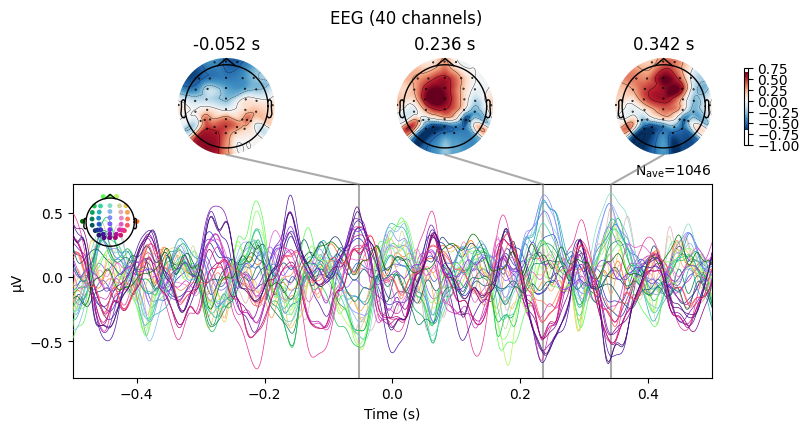

In [4]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)

epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)

### Features

In [5]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from Subj1/exp_full_flow/features/per_channel/features.feather
Got features from Subj1/exp_full_flow/features/dissimilarity/features.feather
Got features from Subj1/exp_full_flow/features/overall/features.feather


,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,20.0,0.0,3.081388,0.0,0.0,0.0,0.0,22.648126,1.984461,74.0,...,0.000079,6.284464e-07,0.000237,0.000079,0.000079,0.000079,-1.500000,0.694641,0.000237,0.000137
1,25.0,0.0,3.634848,0.0,0.0,0.0,0.0,36.287665,0.716812,74.0,...,0.000086,6.442289e-06,0.000259,0.000083,0.000089,0.000091,-1.500000,-0.495956,0.000259,0.000150
2,14.0,0.0,2.522625,0.0,0.0,0.0,0.0,21.617551,1.419534,62.0,...,0.000086,2.472704e-06,0.000258,0.000084,0.000085,0.000087,-1.500000,0.356254,0.000258,0.000149
3,10.0,0.0,1.874874,0.0,0.0,0.0,0.0,24.055291,-0.873622,50.0,...,0.000118,1.172669e-05,0.000354,0.000114,0.000126,0.000126,-1.500000,-0.705968,0.000354,0.000205
4,6.0,0.0,1.614330,0.0,0.0,0.0,0.0,19.211195,-2.146474,44.0,...,0.000071,0.000000e+00,0.000071,0.000071,0.000071,0.000071,0.000000,0.000000,0.000071,0.000071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,13.0,0.0,1.693720,0.0,0.0,0.0,0.0,34.348393,3.916706,48.0,...,0.000157,3.084008e-05,0.001569,0.000142,0.000143,0.000191,-1.511026,0.037182,0.001569,0.000506
1042,6.0,0.0,0.953463,0.0,0.0,0.0,0.0,18.193333,1.887856,30.0,...,0.000178,3.527353e-05,0.001069,0.000154,0.000155,0.000207,-1.453271,0.710438,0.001069,0.000445
1043,12.0,0.0,1.847740,0.0,0.0,0.0,0.0,24.860106,2.853318,46.0,...,0.000126,0.000000e+00,0.000126,0.000126,0.000126,0.000126,0.000000,0.000000,0.000126,0.000126
1044,5.0,0.0,0.864566,0.0,0.0,0.0,0.0,13.957999,1.500518,28.0,...,0.000117,5.181228e-07,0.000234,0.000117,0.000117,0.000117,-2.000000,0.000000,0.000234,0.000165


In [6]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 betti dim-1 max,channel-0 betti dim-1 mean,channel-0 betti dim-1 std,channel-0 betti dim-1 sum,channel-0 betti dim-1 percentile-25,channel-0 betti dim-1 median,channel-0 betti dim-1 percentile-75,channel-0 betti dim-1 kurtosis,channel-0 betti dim-1 skew,channel-0 betti dim-1 norm-1,...,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 percentile-25,overall bd2 dim-3 median,overall bd2 dim-3 percentile-75,overall bd2 dim-3 kurtosis,overall bd2 dim-3 skew,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,1.740911,0.0,2.110733,0.0,0.0,0.0,0.0,-0.523849,0.244968,2.852528,...,-0.291732,-0.637585,-0.398783,-0.242549,-0.305271,-0.342706,-0.707397,1.361278,-0.398783,-0.358632
1,2.719414,0.0,2.979147,0.0,0.0,0.0,0.0,0.748634,-0.371046,2.852528,...,-0.151636,0.018949,-0.352795,-0.151771,-0.115099,-0.136724,-0.707397,-0.701141,-0.352795,-0.269469
2,0.566708,0.0,1.234001,0.0,0.0,0.0,0.0,-0.619995,-0.029558,1.828477,...,-0.157325,-0.429321,-0.354662,-0.126262,-0.176243,-0.196790,-0.707397,0.775105,-0.354662,-0.275374
3,-0.216094,0.0,0.217640,0.0,0.0,0.0,0.0,-0.392569,-1.143917,0.804425,...,0.448923,0.615695,-0.155652,0.453311,0.586774,0.497639,-0.707397,-1.064935,-0.155652,0.104824
4,-0.998896,0.0,-0.191170,0.0,0.0,0.0,0.0,-0.844493,-1.762459,0.292400,...,-0.444769,-0.708553,-0.744440,-0.393258,-0.449392,-0.491009,0.810932,0.157982,-0.744440,-0.804797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,0.371008,0.0,-0.066602,0.0,0.0,0.0,0.0,0.567712,1.183942,0.633750,...,1.190094,2.774092,2.373848,1.018122,0.916795,1.652314,-0.718557,0.222390,2.373848,2.138891
1042,-0.998896,0.0,-1.228111,0.0,0.0,0.0,0.0,-0.939453,0.198023,-0.902327,...,1.593141,3.274745,1.332063,1.255880,1.136752,1.933515,-0.660097,1.388642,1.332063,1.726088
1043,0.175307,0.0,0.175064,0.0,0.0,0.0,0.0,-0.317485,0.667189,0.463075,...,0.608793,-0.708553,-0.629157,0.704803,0.594051,0.499688,0.810932,0.157982,-0.629157,-0.429753
1044,-1.194596,0.0,-1.367594,0.0,0.0,0.0,0.0,-1.334583,0.009796,-1.073002,...,0.429385,-0.650044,-0.405427,0.512682,0.416366,0.335619,-1.213507,0.157982,-0.405427,-0.165668


### Feature selection

In [113]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 14,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = 0.5,
    min_unique_values = 40
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
display(best_features)
display(scores)

,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 percentile-75,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 silhouette-1 dim-1 max,channel-0 silhouette-1 dim-1 mean,channel-0 silhouette-1 dim-1 std,channel-0 silhouette-1 dim-1 sum,channel-0 silhouette-1 dim-1 percentile-75,...,overall silhouette-2 dim-1 percentile-75,overall silhouette-2 dim-1 kurtosis,overall amplitude-landscape-1-1 dim-3,overall amplitude-landscape-1-2 dim-3,overall bd2 all norm-2,overall bd2 dim-1 sum,overall bd2 dim-1 norm-1,overall bd2 dim-1 norm-2,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1
0,-0.520502,-0.520502,-0.150636,-0.520502,-0.633313,-0.569798,-0.380670,-0.488455,-0.380670,-0.127411,...,-0.198620,0.111116,-0.539349,-0.530916,0.445336,1.135221,1.135221,0.704229,-0.398783,-0.398783
1,-0.551943,-0.551943,-0.150636,-0.551943,-0.735120,-0.673813,-0.403483,-0.538255,-0.403483,-0.127411,...,-0.198620,-0.514816,-0.539349,-0.530916,0.390763,1.043360,1.043360,0.789946,-0.352795,-0.352795
2,-0.407366,-0.407366,-0.150636,-0.407366,-0.469525,-0.423210,-0.339031,-0.411784,-0.339031,-0.127411,...,-0.198620,0.268013,-0.347512,-0.370832,0.332392,0.679854,0.679854,0.395351,-0.354662,-0.354662
3,-0.345601,-0.345601,-0.150636,-0.345601,-0.500104,-0.648575,-0.366175,-0.517864,-0.366175,-0.127411,...,-0.198620,-0.358220,-0.060411,-0.131250,0.364773,0.536110,0.536110,0.662948,-0.155652,-0.155652
4,-0.464006,-0.464006,-0.150636,-0.464006,-0.591066,-0.448725,-0.349089,-0.416720,-0.349089,-0.127411,...,-0.198620,-0.099940,-0.445638,-0.452716,0.460320,1.504026,1.504026,0.885237,-0.744440,-0.744440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,0.815099,0.815099,-0.150636,0.815099,0.997798,0.644301,0.340212,0.469666,0.340212,-0.127411,...,-0.198620,-0.268725,3.065094,3.893175,1.618025,0.855649,0.855649,1.248304,2.373848,2.373848
1042,3.271276,3.271276,0.501800,3.271276,3.386493,2.203729,2.671206,2.725941,2.671206,0.023894,...,2.862189,-0.706857,-0.041432,-0.115412,2.056730,0.148281,0.148281,1.446911,1.332063,1.332063
1043,0.208674,0.208674,-0.150636,0.208674,0.407828,0.480932,0.133287,0.362325,0.133287,-0.127411,...,-0.198620,-0.745147,-0.434815,-0.443684,-0.542870,-1.137874,-1.137874,-0.557530,-0.629157,-0.629157
1044,0.733759,0.733759,-0.150636,0.733759,0.857392,0.779406,0.478075,0.671707,0.478075,-0.127411,...,-0.198620,0.883327,-0.539349,-0.530916,-0.956489,-1.385140,-1.385140,-1.011251,-0.405427,-0.405427


,name,score,mean,variance,unique_values,normalized_score
0,channel-0 betti dim-1 max,0.602317,1.358590e-17,1.0,31,0.156897
1,channel-0 betti dim-1 mean,0.000000,0.000000e+00,0.0,1,0.031732
2,channel-0 betti dim-1 std,0.605209,-4.347489e-16,1.0,376,0.157498
3,channel-0 betti dim-1 sum,0.000000,0.000000e+00,0.0,1,0.031732
4,channel-0 betti dim-1 percentile-25,0.000000,0.000000e+00,0.0,1,0.031732
...,...,...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,1.207155,9.510132e-17,1.0,861,0.282587
19559,overall bd2 dim-3 kurtosis,0.238506,-1.154802e-16,1.0,466,0.081295
19560,overall bd2 dim-3 skew,0.422302,5.943833e-18,1.0,538,0.119489
19561,overall bd2 dim-3 norm-1,2.375467,2.717181e-17,1.0,861,0.525370


In [104]:
pca = sklearn.decomposition.PCA(n_components = 15, svd_solver = 'full', random_state = 42)
f = pca.fit_transform(best_features)
print(numpy.sum(pca.explained_variance_ratio_))

sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
result, _ = sda.apply(f)

0.48296584481081384
Applying to 1046 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:07<00:00, 86.15it/s] 


In [105]:
res = SDA.analytics.best_result(result, key = 'Avg-Silh', n_stages = N_STAGES)
display(SDA.analytics.best_results(result, key = 'Avg-Silh'))
print(res)

,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,40,40,20,Median,40,"[0, 205, 1046]",2,841,205,523.000000,74618.825561,21.277231,0.209919,107.814137,1.888578,0.209919,107.814137,1.888578
1,40,40,20,Median,40,"[0, 205, 842, 1046]",3,637,204,348.666667,36170.800806,13.764973,0.075191,60.202993,4.506812,0.136755,56.627146,3.863397
2,0,45,10,Mode,40,"[0, 252, 556, 659, 1046]",4,387,103,261.500000,44697.899610,21.809077,0.020318,66.589716,4.578806,0.263726,74.548508,1.924914
3,20,50,20,Mode,40,"[0, 124, 193, 556, 659, 1046]",5,387,69,209.200000,30444.277877,19.975827,0.013977,52.384925,4.431019,0.244758,49.529877,2.301461
4,20,50,20,Mode,40,"[0, 124, 193, 556, 659, 788, 1046]",6,363,69,174.333333,27959.324009,19.645253,0.016050,47.085687,3.757100,0.209916,44.991839,2.357321
5,0,35,20,Mode,40,"[0, 141, 252, 556, 603, 682, 788, 1046]",7,304,47,149.428571,19261.776084,18.268292,0.001806,41.728446,4.343354,0.198518,34.010491,2.685545
6,0,35,20,Mode,40,"[0, 141, 193, 252, 556, 603, 682, 788, 1046]",8,304,47,130.750000,15362.557702,17.371116,-0.017503,37.259385,3.952303,0.177581,26.636350,2.632074
7,60,35,20,Mode,40,"[0, 124, 193, 290, 556, 682, 788, 871, 971, 1046]",9,266,69,116.222222,17331.136322,16.319928,-0.038210,35.331084,4.877763,0.144569,27.994922,2.529683
8,0,35,20,Mode,40,"[0, 141, 193, 252, 556, 603, 682, 788, 871, 97...",10,304,47,104.600000,12547.785329,16.285860,-0.052062,31.820209,4.772374,0.155878,22.535378,2.691661
9,0,35,20,Mode,40,"[0, 141, 193, 290, 508, 556, 603, 682, 788, 87...",11,218,47,95.090909,10018.367708,15.108593,-0.046199,29.693982,4.521217,0.137013,17.479262,2.822575


{'St_len_min': 60, 'K_nb_max': 35, 'N_cl_max': 20, 'Cl_cen': 'Mode', 'Len_min': 40, 'St_edges': array([   0,  124,  193,  290,  556,  682,  788,  871,  971, 1046]), 'N_stages': 9, 'Longest_stage': 266, 'Shortest_stage': 69, 'Avg_stage_length': 116.22222222222223, 'Ward_dist': 17331.136321881608, 'Cen_dist': 16.319928432163877, 'Silh': -0.03820974553316499, 'Cal-Har': 35.331083903950656, 'Dav-Bold': 4.877763079927025, 'Avg-Silh': 0.14456871468849336, 'Avg-Cal-Har': 27.994921661534935, 'Avg-Dav-Bold': 2.5296825515115775}


In [106]:
# [0, 104, 282, 492, 560, 682, 784, 857, 976, 1046]
print(SDA.clustquality.calc_stage_metr_noground(features, res["St_edges"], [ "Silh" ]).mean()["Silh"])
print(SDA.clustquality.cluster_metrics_ground(numpy.array([0, 104, 282, 492, 560, 682, 784, 857, 976, 1046]), res["St_edges"], [ "FMI" ])["FMI"])

0.03452180899511287
0.7832239678281321


In [107]:
df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

features_neuro = pandas.concat([ df_ft_psd_loc_db, df_ft_psd_ind_loc_log, df_ft_coh_ind_loc, df_ft_plv_ind_loc ], axis = 1)
print(features_neuro.shape)

features_neuro = sklearn.preprocessing.StandardScaler().fit_transform(features_neuro)
print(features_neuro.shape)

print(SDA.clustquality.calc_stage_metr_noground(features_neuro, res["St_edges"], [ "Silh" ]).mean()["Silh"])

(1046, 765)
(1046, 765)
0.1179948894214568


In [108]:
neuro_pca = sklearn.decomposition.PCA(n_components = 15, svd_solver = "full", random_state = 42).fit_transform(features_neuro)
print(SDA.clustquality.calc_stage_metr_noground(neuro_pca, res["St_edges"], [ "Silh" ]).mean()["Silh"])

0.167131235855892


In [68]:
sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
result, _ = sda.apply(neuro_pca)
display(SDA.analytics.best_results(result, key = 'Avg-Silh'))

Applying to 1046 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:08<00:00, 79.29it/s] 


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,20,50,20,Mode,40,"[0, 682, 1046]",2,682,364,523.000000,27180.311040,10.701636,0.054252,52.403364,4.093958,0.054252,52.403364,4.093958
1,0,35,10,Mode,40,"[0, 282, 560, 1046]",3,486,278,348.666667,42308.816307,16.400094,0.072681,114.988709,2.722181,0.125930,108.777275,2.438303
2,40,35,15,Median,40,"[0, 168, 560, 857, 1046]",4,392,168,261.500000,33307.136107,15.081889,0.070873,89.780730,3.560225,0.127895,86.288835,3.119853
3,40,50,10,Median,40,"[0, 178, 560, 682, 857, 1046]",5,382,122,209.200000,45198.297789,21.835308,0.084183,105.595294,2.586946,0.211379,121.129124,1.797900
4,0,40,20,Mode,40,"[0, 282, 560, 682, 857, 976, 1046]",6,282,70,174.333333,40140.388425,22.231911,0.045818,93.686293,3.333972,0.211703,106.561195,1.713502
5,0,40,20,Mode,40,"[0, 282, 560, 682, 784, 857, 976, 1046]",7,282,70,149.428571,32917.008275,22.056582,0.054187,88.087515,3.300626,0.217008,91.748882,1.659530
6,0,45,20,Mode,40,"[0, 282, 492, 560, 682, 784, 857, 976, 1046]",8,282,68,130.750000,27253.008639,21.718176,0.051832,83.870140,3.088252,0.209468,77.976804,1.643116
7,60,45,15,Median,40,"[0, 104, 282, 492, 560, 682, 784, 857, 976, 1046]",9,210,68,116.222222,22992.134911,20.577614,0.051424,84.802755,3.014466,0.197820,66.881786,1.740748
8,0,40,15,Mode,40,"[0, 92, 154, 282, 492, 560, 682, 784, 857, 976...",10,210,62,104.600000,19921.966427,19.978023,0.055157,80.814883,2.941300,0.197371,59.065692,1.797313
9,40,40,15,Mode,40,"[0, 92, 154, 282, 492, 560, 609, 682, 784, 857...",11,210,49,95.090909,17433.673781,20.010478,0.047344,76.533681,2.935801,0.205210,56.018632,1.818006


### Dimensionality reduction attempts

In [21]:
print(TRY_NUM_FEATURES)
for n_components in TRY_NUM_FEATURES:
    file = f"{subj}/{exp}/features_reduced/ae/{n_components}/features.npy"
    if not os.path.exists(file):
        raise NotImplementedError(f'Need to run AE for {n_components} components manually')
    
class AutoEncoder:
    def __init__(self, n_components: int):
        self.n_components = n_components

    def fit_transform(self, features: numpy.ndarray):
        return numpy.load(f"{subj}/{exp}/features_reduced/ae/{n_components}/features.npy")

[ 10  13  19  28  40  55  73  94 118 145 175 208 244 283 325 370 418 469
 523 580 640 703 769 838 910]


In [22]:
print(TRY_NUM_FEATURES)
for n_components in TRY_NUM_FEATURES:
    file = f"{subj}/{exp}/features_reduced/rtd_ae/{n_components}/features.npy"
    if not os.path.exists(file):
        raise NotImplementedError(f'Need to run RTD_AE for {n_components} components manually')
    
class RTDAutoEncoder:
    def __init__(self, n_components: int):
        self.n_components = n_components

    def fit_transform(self, features: numpy.ndarray):
        return numpy.load(f"{subj}/{exp}/features_reduced/rtd_ae/{n_components}/features.npy")

[ 10  13  19  28  40  55  73  94 118 145 175 208 244 283 325 370 418 469
 523 580 640 703 769 838 910]


In [23]:
def make_reduced(
    methods: typing.List[typing.Tuple[str, typing.Callable[[numpy.ndarray], numpy.ndarray]]],
    full_features: pandas.DataFrame
):
    def reduce(name: str, method, n_components: int, full_features: numpy.ndarray):
        folder = f"{subj}/{exp}/features_reduced/{name}/{n_components}"
        os.makedirs(folder, exist_ok = True)
        
        features_file = f"{folder}/features.npy"
        if os.path.exists(features_file):
            reduced_features = numpy.load(features_file)
        else:
            reduced_features = method.fit_transform(full_features)
            numpy.save(features_file, reduced_features)
        
        results_file = f"{folder}/results.csv"
        df_st_edges_file = f"{folder}/df_st_edges.csv"
        if not os.path.exists(results_file) or not os.path.exists(df_st_edges_file):
            sda = SDA.SDA(n_jobs = 1, scale = False, verbose = False)
            results, df_st_edges = sda.apply(reduced_features)
            df_st_edges.to_csv(df_st_edges_file, index = False)
            results.to_csv(results_file, index = False)

    generator = joblib.Parallel(return_as = "generator", n_jobs = -1)(
        joblib.delayed(reduce)(name, method(n_components = n_components, **params), n_components, full_features.to_numpy())
        for n_components, (name, method, params) in itertools.product(TRY_NUM_FEATURES, methods)
    )
    list(tqdm.tqdm(generator, total = len(methods) * len(TRY_NUM_FEATURES)))

methods = [
    ('pca', sklearn.decomposition.PCA, { 'svd_solver': "full", 'random_state': 42 }),
    ('umap', umap.UMAP, { 'random_state': 42 }),
    ('ae', AutoEncoder, { }),
    ('rtd_ae', RTDAutoEncoder, { })
]
make_reduced(methods, features)

100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


rtd_ae: 100%|██████████| 25/25 [00:12<00:00,  1.99it/s]


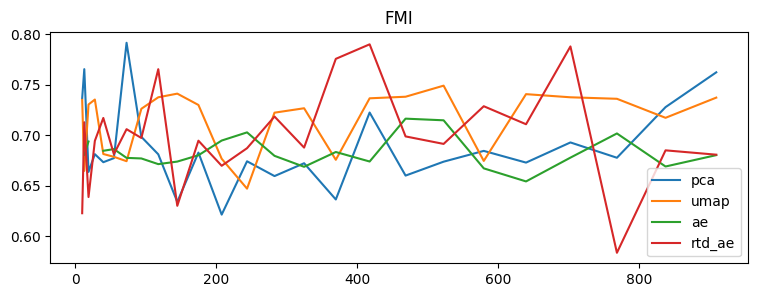

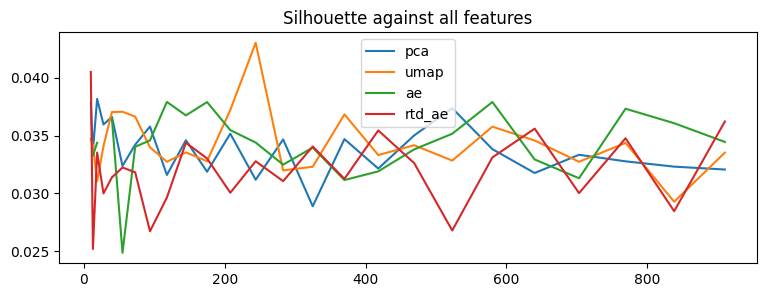

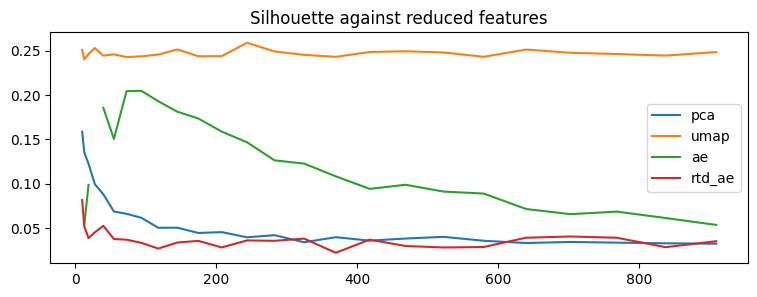

In [33]:
fig_fmi, ax_fmi = plt.subplots(1, 1, figsize = (9, 3))
fig_silh_all, ax_silh_all = plt.subplots(1, 1, figsize = (9, 3))
fig_silh_reduced, ax_silh_reduced = plt.subplots(1, 1, figsize = (9, 3))

for (name, _, __) in methods:
    fmis = [ ]
    silh_all = [ ]
    silh_reduced = [ ]

    for n_components in tqdm.tqdm(TRY_NUM_FEATURES, desc = name):
        reduced_features = numpy.load(f"{subj}/{exp}/features_reduced/{name}/{n_components}/features.npy")

        results = pandas.read_csv(f"{subj}/{exp}/features_reduced/{name}/{n_components}/results.csv")
        try:
            result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
            edges = numpy.fromstring(result['St_edges'].strip('[]'), sep = ' ', dtype = numpy.uint)
        except:
            edges = None
    
        if edges is not None:
            fmis.append(SDA.clustquality.cluster_metrics_ground(edges_true, edges, [ "FMI" ])["FMI"])
            silh_all.append(SDA.clustquality.calc_stage_metr_noground(features, edges, [ "Silh" ]).mean()["Silh"])
            silh_reduced.append(SDA.clustquality.calc_stage_metr_noground(reduced_features, edges, [ "Silh" ]).mean()["Silh"])
        else:
            fmis.append(None)
            silh_all.append(None)
            silh_reduced.append(None)
        
    ax_fmi.plot(TRY_NUM_FEATURES, fmis, label = name)
    ax_silh_all.plot(TRY_NUM_FEATURES, silh_all, label = name)
    ax_silh_reduced.plot(TRY_NUM_FEATURES, silh_reduced, label = name)

ax_fmi.set_title("FMI")
ax_silh_all.set_title("Silhouette against all features")
ax_silh_reduced.set_title("Silhouette against reduced features")

ax_fmi.legend()
ax_silh_all.legend()
ax_silh_reduced.legend()

fig_fmi.savefig(f"{subj}/{exp}/features_reduced/fmi.svg")
fig_silh_all.savefig(f"{subj}/{exp}/features_reduced/silh_all.svg")
fig_silh_reduced.savefig(f"{subj}/{exp}/features_reduced/silh_reduced.svg")

### Information value